In [1]:
!pip install -U transformers datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cud

In [2]:
import pandas as pd
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch

In [3]:
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive'
    print(path_to_file)
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive


In [4]:
import pandas as pd
import re
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast
import matplotlib.pyplot as plt

In [5]:
kaggle_ds = pd.read_csv("twitter_MBTI.csv")
kaggle_ds.drop(columns=["Unnamed: 0"], inplace=True)
kaggle_ds.columns = ["post", "type"]
kaggle_ds.head()

,post,type
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj


In [6]:
tianchi_ds = pd.read_csv(f"mbti_1.csv")
tianchi_ds.columns = ["type", "post"]
tianchi_ds.head()

,type,post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [7]:
def explode_column(df, col_to_explode, sep = r"\|\|\|"):
    """
    Split the specified column of a DataFrame into multiple rows by a separator,
    preserving all other columns unchanged.

    param
    ----
    df : imported dataframes
    col_to_explode : str columns want to split
    sep : str regularize expression for "|||"
    """
    df_copy = df.copy()
    # 1) split the text with "|||"
    df_copy[col_to_explode] = df_copy[col_to_explode].str.split(sep)
    # 2) explode
    df_exploded = df_copy.explode(col_to_explode)
    # 3) reset index
    return df_exploded.reset_index(drop=True)

In [8]:
df1 = explode_column(kaggle_ds, "post")
df2 = explode_column(tianchi_ds, "post")

In [9]:
df = pd.concat([df1, df2], ignore_index=True)
df["type"].unique()

array(['intj', 'intp', 'entj', 'entp', 'infj', 'infp', 'enfj', 'enfp',
       'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp',
       'INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

In [10]:
def clean_text(text):
  """
  clean to text, to lower case, remove abnormal characters or strings like http, @, *, #, etc
  input: str
  output: str
  """
  text = text.lower() #to lower case
  text = re.sub(r"https?://\S+", "", text) #remove links
  text = re.sub(r"@\w+", "", text) #remove @nickname
  text = re.sub(r"#\w+", "", text) #remove 话题
  text = re.sub(r"&amp;|&lt;|&gt;", "", text) #remove all HTML specific entities, avoid left in post
  text = re.sub(r"[^0-9a-zA-Z\s.,!?;:'\"()\[\]{}]", "", text) #keep only numbers, letters, and  punctuaion
  text = re.sub(r"\s+", " ", text).strip() #only keep one space if there are multiple
  return text

In [11]:
df["post"] = df["post"].apply(clean_text)
df['type']=df['type'].apply(clean_text)

In [12]:
df

,post,type
0,"the pope is infallible, this is a catholic dog...",intj
1,and by perpetually it entails that the church ...,intj
2,you open the door to unironic nonsense when yo...,intj
3,you dont know your own faith lol you just trie...,intj
4,thats like me saying that im gonna give you a ...,intj
...,...,...
1516039,i was going to close my facebook a few months ...,infp
1516040,30 seconds to mars all of my collections. it s...,infp
1516041,"i have seen it, and i agree. i did actually th...",infp
1516042,ok so i have just watched underworld 4 (awaken...,infp


In [13]:
le = LabelEncoder()
df["label_16"] = le.fit_transform(df["type"])  # 0–15
#四维encoding
df['E'] = df["type"].str[0].map({"e":1, "i":0})
df['N'] = df["type"].str[1].map({"n":1, "s":0})
df['T'] = df["type"].str[2].map({"t":1, "f":0})
df['P'] = df["type"].str[3].map({"p":1, "j":0})

In [14]:
# Undersample to balance 16‑class
X = df[["post"]].values
y = df["label_16"].values
rus = RandomUnderSampler(sampling_strategy="not minority", random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# rebuild DataFrame after resampling
df_resampled = pd.DataFrame({
    "posts": X_res.ravel(),
    "label_16": y_res
})

In [15]:
# rebuild DataFrame after resampling
df_resampled = pd.DataFrame({
    "posts": X_res.ravel(),
    "label_16": y_res
})

In [16]:
# regenerate the four binary dims
df_resampled['type'] = le.inverse_transform(df_resampled["label_16"])
df_resampled['E'] = df_resampled["type"].str[0].map({"e":1, "i":0})
df_resampled['N'] = df_resampled["type"].str[1].map({"n":1, "s":0})
df_resampled['T'] = df_resampled["type"].str[2].map({"t":1, "f":0})
df_resampled['P'] = df_resampled["type"].str[3].map({"p":1, "j":0})

In [17]:
df_resampled

,posts,label_16,type,E,N,T,P
0,moveee this was my jam,0,enfj,1,1,0,0
1,pls no,0,enfj,1,1,0,0
2,as a fan it is hard for me to say this but i l...,0,enfj,1,1,0,0
3,"bob saget and oprah, apparently. i've heard pe...",0,enfj,1,1,0,0
4,i know what all of you are thinking and none o...,0,enfj,1,1,0,0
...,...,...,...,...,...,...,...
225323,yall never believe me when i say i get bitches...,15,istp,0,0,1,1
225324,"can't draw, can't write a song, can't make som...",15,istp,0,0,1,1
225325,social media wanna look minimal so bad,15,istp,0,0,1,1
225326,i stopped caring when i wanted more bacon.,15,istp,0,0,1,1


In [18]:
from datasets import Dataset
import torch
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

df = df_resampled.copy()
df["text"] = df["posts"].astype(str)
df["label"] = df["label_16"]


df_train, df_val = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=42)
train_ds = Dataset.from_pandas(df_train[["text", "label"]].reset_index(drop=True))
val_ds = Dataset.from_pandas(df_val[["text", "label"]].reset_index(drop=True))

In [19]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/202795 [00:00<?, ? examples/s]

Map:   0%|          | 0/22533 [00:00<?, ? examples/s]

In [21]:
from transformers import TrainingArguments
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=16)
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

training_args = TrainingArguments(
    output_dir="./roberta-mbti-output",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-22-ceec72031d5f>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.708400,2.705950,0.112990
2,2.668000,2.682294,0.128922
3,2.600400,2.684870,0.132073


TrainOutput(global_step=38025, training_loss=2.6706003234983666, metrics={'train_runtime': 13746.5837, 'train_samples_per_second': 44.257, 'train_steps_per_second': 2.766, 'total_flos': 4.002323515619328e+16, 'train_loss': 2.6706003234983666, 'epoch': 3.0})

In [23]:
trainer.evaluate()

{'eval_loss': 2.6848702430725098,
 'eval_accuracy': 0.13207295965916654,
 'eval_runtime': 146.767,
 'eval_samples_per_second': 153.529,
 'eval_steps_per_second': 9.6,
 'epoch': 3.0}

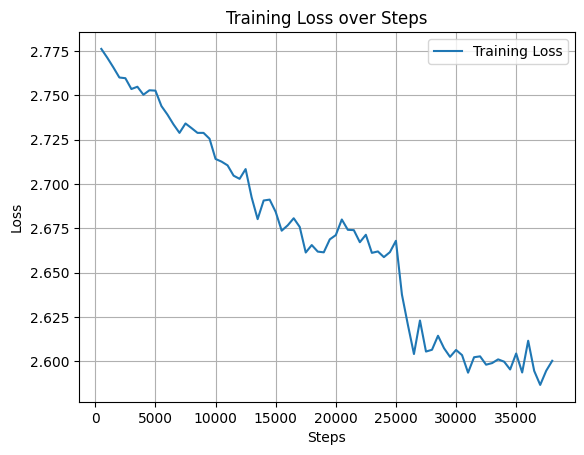

In [24]:
loss_values = []
steps = []

for log in trainer.state.log_history:
    if "loss" in log.keys():
        loss_values.append(log["loss"])
        steps.append(log["step"])

plt.plot(steps, loss_values, label='Training Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid(True)
plt.show()